In [1]:
# Libraries

import argparse
import numpy
import os
import platform
import random
import shutil
import sys

In [2]:
# Ensure source path

ROOT = os.getcwd()

while not ROOT.endswith('upolanc-thesis') :
	ROOT = os.path.abspath(os.path.join(ROOT, os.pardir))

	if len(ROOT) < len('upolanc-thesis') :
		if   platform.system() == 'Linux' :
			ROOT = '/d/hpc/home/up4472/workspace/upolanc-thesis'
		elif platform.system() == 'Windows' :
			ROOT = 'C:\\Developer\\Workspace\\PyCharm\\Projects\\upolanc-thesis'
		else :
			raise ValueError()

		print(f'Warning : could not find correct directory, using default : {ROOT}')
		break

if ROOT not in sys.path :
	sys.path.append(ROOT)

os.chdir(ROOT)

In [3]:
# Code

from source.python.cnn.models import Zrimec2020r
from source.python.cnn.models import Zrimec2020c
from source.python.cnn.models import Washburn2019r
from source.python.cnn.models import Washburn2019c

from source.python.dataset import dataset_split
from source.python.dataset import dataset_utils
from source.python.cnn     import cnn_model
from source.python.cnn     import cnn_mutation
from source.python.cnn     import cnn_plot
from source.python.cnn     import cnn_utils
from source.python.io      import loader
from source.python.io      import writer
from source.python         import runtime

runtime.set_numpy_format()
runtime.set_pandas_format()
runtime.set_plot_theme()

# 1. Setup

In [4]:
# Define output and inputs

FILTER_ID      = 2
VERBOSE        = False
FEATURES       = True
GENERATOR      = 'stratified'

MODEL_ARCH     = 'washburn'
MODEL_MODE     = 'classification'
MODEL_PARAMS   = 0
MODEL_EPOCHS   = 25

SEQUENCE_TYPE  = '1k'
SEQUENCE_END   = None
SEQUENCE_START = None

In [5]:
# Check for args

if __name__ == '__main__' and 'get_ipython' in dir() :
	print('Running as .ipynb')
	print()

if __name__ == '__main__' and 'get_ipython' not in dir() :
	print('Running as .py')
	print()

	parser = argparse.ArgumentParser()

	str_of_bool = lambda x : True if x == 'true' else False
	str_or_none = lambda x : None if x == 'none' else str(x)
	int_or_none = lambda x : None if x == 'none' else int(x)

	parser.add_argument('--model_arch',     type = str,         default = 'zrimec',     choices = ['zrimec', 'washburn'])
	parser.add_argument('--model_epochs',   type = int,         default = 250)
	parser.add_argument('--model_params',   type = int_or_none, default = None)
	parser.add_argument('--filter_id',      type = int,         default = 0)
	parser.add_argument('--generator',      type = str,         default = 'stratified', choices = ['stratified', 'group', 'random'])
	parser.add_argument('--features',       type = str_of_bool, default = False)
	parser.add_argument('--sequence_start', type = int_or_none, default = None)
	parser.add_argument('--sequence_end',   type = int_or_none, default = None)
	parser.add_argument('--sequence_type',  type = str,         default = '1k',         choices = ['5k', '1k'])

	args = vars(parser.parse_args())

	MODEL_EPOCHS   = args['model_epochs']
	MODEL_PARAMS   = args['model_params']
	FILTER_ID      = args['filter_id']
	GENERATOR      = args['generator']
	FEATURES       = args['features']
	SEQUENCE_START = args['sequence_start']
	SEQUENCE_END   = args['sequence_end']
	SEQUENCE_TYPE  = args['sequence_type']

Running as .ipynb



In [6]:
# Setup some directory paths.

SUBFOLDER = 'filter' + str(FILTER_ID)
FOLDER    = '{}-f{}-{}'.format(MODEL_ARCH, FILTER_ID, MODEL_MODE[0])

CWD = ROOT
OUT = os.path.join(CWD, 'output')
RES = os.path.join(CWD, 'resources')

OUT_DATA  = os.path.join(OUT,      'nbp07-switch',  FOLDER)
OUT_MODEL = os.path.join(OUT_DATA, 'model')
OUT_PLOT  = os.path.join(OUT_DATA, 'plot')
RES_NBP02 = os.path.join(OUT,      'nbp02-anndata', SUBFOLDER)
RES_NBP04 = os.path.join(OUT,      'nbp04-feature', SUBFOLDER)
RES_NBP05 = os.path.join(OUT,      'nbp05-target',  SUBFOLDER)

shutil.rmtree(OUT_DATA, ignore_errors = True)

os.makedirs(OUT_DATA,  exist_ok = True)
os.makedirs(OUT_MODEL, exist_ok = True)
os.makedirs(OUT_PLOT,  exist_ok = True)

print(f'     Root Directory : {CWD}')
print(f'   Output Directory : {OUT_DATA}')
print(f'   Output Directory : {OUT_MODEL}')
print(f'   Output Directory : {OUT_PLOT}')
print(f' Resource Directory : {RES_NBP02}')
print(f' Resource Directory : {RES_NBP04}')
print(f' Resource Directory : {RES_NBP05}')
print()

     Root Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis
   Output Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp07-switch\washburn-f2-c
   Output Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp07-switch\washburn-f2-c\model
   Output Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp07-switch\washburn-f2-c\plot
 Resource Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp02-anndata\filter2
 Resource Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp04-feature\filter2
 Resource Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp05-target\filter2



In [7]:
# System and device

DEVICE = runtime.get_device(only_cpu = False)
SYSTEM = runtime.get_system_info()

for key, value in SYSTEM.items() :
	print('{:25s} : {}'.format(key, value))

print()

platform/python           : 3.10.7
platform/system           : Windows
platform/release          : 10
platform/version          : 10.0.19044
platform/cpu/name         : N/A
platform/cpu/count        : 12
platform/gpu/name         : NVIDIA GeForce RTX 3060 Ti
platform/gpu/available    : True
platform/gpu/count        : 1
platform/memory/total     : 31.924 GB
platform/memory/available : 18.849 GB



In [8]:
# Define sequence paths

if SEQUENCE_TYPE == '5k' :
	sequence_keep = os.path.join(RES_NBP04, 'sequences-6150-keep.fasta')
	sequence_drop = os.path.join(RES_NBP04, 'sequences-6150-drop.fasta')

if SEQUENCE_TYPE == '1k' :
	sequence_keep = os.path.join(RES_NBP04, 'sequences-2150-keep.fasta')
	sequence_drop = os.path.join(RES_NBP04, 'sequences-2150-drop.fasta')

if MODEL_ARCH == 'zrimec'   : model_config = os.path.join(RES, 'tuner', 'zrimec.json')
if MODEL_ARCH == 'washburn' : model_config = os.path.join(RES, 'tuner', 'washburn.json')

In [9]:
# Load the input transcript features

sequence_keep = loader.load_fasta(
	filename  = sequence_keep,
	to_string = True
)

sequence_drop = loader.load_fasta(
	filename  = sequence_drop,
	to_string = True
)

feature_base_keep = loader.load_npz(
	filename = os.path.join(RES_NBP04, 'features-base-keep.npz')
)

feature_base_drop = loader.load_npz(
	filename = os.path.join(RES_NBP04, 'features-base-drop.npz')
)

model_config = loader.load_json(
	filename = model_config
)

# 2. Config

In [10]:
# Create final report

final_report = dict()

In [11]:
# Single global config

CONFIG = {
	'core/device'                  : DEVICE,
	'core/random'                  : None,
	'core/rootdir'                 : ROOT,
	'core/verbose'                 : VERBOSE,
	'core/plots'                   : 5,
	'dataset/expanddim'            : 0,
	'dataset/sequence/start'       : SEQUENCE_START,
	'dataset/sequence/end'         : SEQUENCE_END,
	'dataset/sequence/type'        : SEQUENCE_TYPE,
	'dataset/split/generator'      : GENERATOR,
	'dataset/split/test'           : 0.2,
	'dataset/split/valid'          : 0.2,
	'model/name'                   : MODEL_ARCH,
	'model/mode'                   : MODEL_MODE,
	'model/epochs'                 : MODEL_EPOCHS,
	'model/features'               : FEATURES,
	'model/input/channels'         : 1,
	'model/input/features'         : None,
	'model/input/height'           : 4,
	'model/input/width'            : 2150,
	'model/output/heads'           : None,
	'model/output/size'            : None,
	'model/params/id'              : MODEL_PARAMS
}

CONFIG['core/random'] = runtime.lock_random(
	seed     = CONFIG['core/random'],
	generate = True
)

In [12]:
# Update specific params

if CONFIG['model/params/id'] is not None and CONFIG['model/params/id'] >= 0 :
	CONFIG.update(model_config[CONFIG['model/params/id']])

	CONFIG['dataset/batch/train'] = CONFIG['dataset/batch_size']
	CONFIG['dataset/batch/valid'] = CONFIG['dataset/batch_size']
	CONFIG['dataset/batch/test']  = CONFIG['dataset/batch_size']

In [13]:
# Update configuratio

if CONFIG['model/name'] == 'zrimec'   : CONFIG['dataset/expanddim'] = None
if CONFIG['model/name'] == 'washburn' : CONFIG['dataset/expanddim'] = 0

if CONFIG['model/mode'] == 'regression'     : CONFIG['criterion/name'] = 'mse'
if CONFIG['model/mode'] == 'classification' : CONFIG['criterion/name'] = 'bce'

In [14]:
# Prints

print('Use Features  : {}'.format(CONFIG['model/features']))
print('Random Seed   : {}'.format(CONFIG['core/random']))
print()

Use Features  : True
Random Seed   : 93150838



# 3. Dataloader

## 3.1 Targets

In [15]:
# Define target classes

targets_keep = {k : numpy.array([1], dtype = numpy.float64) for k in sequence_keep.keys()}
targets_drop = {k : numpy.array([0], dtype = numpy.float64) for k in sequence_drop.keys()}

## 3.2 Sampling

In [16]:
# Random undersampling until better code

undersamples = random.choices(list(sequence_keep.keys()), k = int(1.10 * len(sequence_drop)))

sequence_keep     = {k : v for k, v in sequence_keep.items()     if k in undersamples}
feature_base_keep = {k : v for k, v in feature_base_keep.items() if k in undersamples}
targets_keep      = {k : v for k, v in targets_keep.items()      if k in undersamples}

## 3.3 Merge

In [17]:
# Merge data

sequence = {k : v for k, v in sequence_keep.items()}
features = {k : v for k, v in feature_base_keep.items()}
targets  = {k : v for k, v in targets_keep.items()}

sequence.update(sequence_drop)
features.update(feature_base_drop)
targets.update(targets_drop)

array = [
	(    sequence_keep,     sequence_drop, sequence, 'Sequence'),
	(feature_base_keep, feature_base_drop, features,  'Feature'),
	(     targets_keep,      targets_drop,  targets,   'Target')
]

for x, y, z, name in array :
	print('{:8s} : {:6,d} + {:6,d} == {:6,d} | {}'.format(name, len(x), len(y), len(z), len(z) == len(x) + len(y)))

x = len(targets_keep)
y = len(targets_drop)

print()
print('Majority Vote : {:.5f}'.format(max(x, y) / (x + y)))
print()

Sequence :  2,008 +  1,912 ==  3,920 | True
Feature  :  2,008 +  1,912 ==  3,920 | True
Target   :  2,008 +  1,912 ==  3,920 | True

Majority Vote : 0.51224



## 3.4 Normal

In [18]:
# Create dataset

CONFIG['model/output/size']    = 1
CONFIG['model/output/heads']   = None
CONFIG['model/input/features'] = len(list(features.values())[0])

start = CONFIG['dataset/sequence/start']
end   = CONFIG['dataset/sequence/end']

dataset = dataset_utils.to_gene_dataset(
	sequences   = sequence,
	features    = features,
	targets     = targets,
	expand_dims = CONFIG['dataset/expanddim'],
	groups      = None,
	start       = start,
	end         = end
)

if start is None : start = 0
if end   is None : end   = len(list(sequence.values())[0])

if start >= end :
	raise ValueError()

CONFIG['model/input/width']  = int(end - start)
CONFIG['model/fc3/features'] = CONFIG['model/output/size']
CONFIG['model/fc3/heads']    = CONFIG['model/output/heads']

print('Input Features : {}'.format(CONFIG['model/input/features']))
print('Output Size    : {}'.format(CONFIG['model/output/size']))
print('Output Heads   : {}'.format(CONFIG['model/output/heads']))
print()

Input Features : 72
Output Size    : 1
Output Heads   : None



In [19]:
# Create dataloader

dataloaders = dataset_utils.to_dataloaders(
	dataset     = dataset,
	generator   = CONFIG['dataset/split/generator'],
	random_seed = CONFIG['core/random'],
	split_size  = {
		'valid' : CONFIG['dataset/split/valid'],
		'test'  : CONFIG['dataset/split/test']
	},
	batch_size  = {
		'train' : CONFIG['dataset/batch/train'],
		'valid' : CONFIG['dataset/batch/valid'],
		'test'  : CONFIG['dataset/batch/test']
	}
)

train_dataloader = dataloaders[0]
valid_dataloader = dataloaders[1]
test_dataloader  = dataloaders[2]

In [20]:
# Display train dataloader

dataset_utils.show_dataloader(
	dataloader = train_dataloader,
	verbose    = CONFIG['core/verbose']
)

In [21]:
# Display valid dataloader

dataset_utils.show_dataloader(
	dataloader = valid_dataloader,
	verbose    = CONFIG['core/verbose']
)

In [22]:
# Display test dataloader

dataset_utils.show_dataloader(
	dataloader = test_dataloader,
	verbose    = CONFIG['core/verbose']
)

# 4. Model

## 4.1 Structure

In [23]:
# Create and display the model structure

if CONFIG['model/name'] == 'zrimec' :
	model = Zrimec2020c(params = CONFIG, binary = True)

	print(model.summary(
		batch_size  = CONFIG['dataset/batch/train'],
		in_height   = CONFIG['model/input/height'],
		in_width    = CONFIG['model/input/width'],
		in_features = CONFIG['model/input/features'],
	))

if CONFIG['model/name'] == 'washburn' :
	model = Washburn2019c(params = CONFIG, binary = True)

	print(model.summary(
		batch_size  = CONFIG['dataset/batch/train'],
		in_channels = CONFIG['model/input/channels'],
		in_height   = CONFIG['model/input/height'],
		in_width    = CONFIG['model/input/width'],
		in_features = CONFIG['model/input/features'],
	))

print()

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
Washburn2019c                            [32, 1, 4, 2150]          [32, 1]                   --
├─Washburn2019: 1-1                      [32, 1, 4, 2150]          [32, 128]                 1,408
│    └─Conv2d: 2-1                       [32, 1, 4, 2150]          [32, 64, 3, 2150]         832
│    └─LeakyReLU: 2-2                    [32, 64, 3, 2150]         [32, 64, 3, 2150]         --
│    └─Conv2d: 2-3                       [32, 64, 3, 2150]         [32, 128, 3, 2150]        41,088
│    └─LeakyReLU: 2-4                    [32, 128, 3, 2150]        [32, 128, 3, 2150]        --
│    └─MaxPool2d: 2-5                    [32, 128, 3, 2150]        [32, 128, 3, 430]         --
│    └─Dropout: 2-6                      [32, 128, 3, 430]         [32, 128, 3, 430]         --
│    └─Conv2d: 2-7                       [32, 128, 3, 430]         [32, 128, 3, 430]         82,048
│    └─LeakyReLU: 2-8  

In [24]:
# Convert the model to double and initialize weights and biases

model = model.double()
model = model.apply(cnn_model.he_uniform_weight)
model = model.apply(cnn_model.zero_bias)

## 4.2 Metrics

In [25]:
# Define metrics

if CONFIG['model/mode'] == 'regression' :
	METRICS = {
		'mse'   : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'mse'),
		'mae'   : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'mae'),
		'smae'  : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'smae'),
		'mape'  : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'mape',  output_size = CONFIG['model/output/size']),
		'wmape' : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'wmape', output_size = CONFIG['model/output/size']),
		'r2'    : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'r2',    output_size = CONFIG['model/output/size']),
	}

if CONFIG['model/mode'] == 'classification' :
	METRICS = {
		'entropy'   : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'bce'),
		'accuracy'  : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'accuracy',  task = 'binary', n_classes = CONFIG['model/output/size']),
		'auroc'     : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'auroc',     task = 'binary', n_classes = CONFIG['model/output/size']),
		'confusion' : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'confusion', task = 'binary', n_classes = CONFIG['model/output/size']),
		'f1'        : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'f1',        task = 'binary', n_classes = CONFIG['model/output/size']),
		'jaccardi'  : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'jaccardi',  task = 'binary', n_classes = CONFIG['model/output/size']),
		'matthews'  : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'matthews',  task = 'binary', n_classes = CONFIG['model/output/size'])
	}

METRICS = {
	k : v.to(DEVICE)
	for k, v in METRICS.items()
}

## 4.3 Parameters

In [26]:
# Set the model parameters

model_trainers = cnn_model.get_model_trainers(
	model  = model,
	config = CONFIG,
	epochs = CONFIG['model/epochs']
)

model_params = {
	'model'     : model,
	'savebest'  : os.path.join(OUT_MODEL, f'{model.__name__}-best.pth'),
	'savelast'  : os.path.join(OUT_MODEL, f'{model.__name__}-last.pth'),
	'savetime'  : os.path.join(OUT_MODEL, f'{model.__name__}-time.pth'),
	'epochs'    : CONFIG['model/epochs'],
	'criterion' : model_trainers['criterion'],
	'optimizer' : model_trainers['optimizer'],
	'scheduler' : model_trainers['scheduler'],
	'device'    : DEVICE,
	'verbose'   : CONFIG['core/verbose'],
	'metrics'   : METRICS,
	'train_dataloader' : train_dataloader,
	'valid_dataloader' : valid_dataloader,
	'test_dataloader'  : test_dataloader
}

## 4.4 Train

In [27]:
# Train and validate the model

if CONFIG['model/mode'] == 'regression' :
	report = cnn_model.train_regressor(
		model  = model,
		params = model_params
	)

if CONFIG['model/mode'] == 'classification' :
	report = cnn_model.train_classifier(
		model  = model,
		params = model_params
	)

## 4.5 Visualization

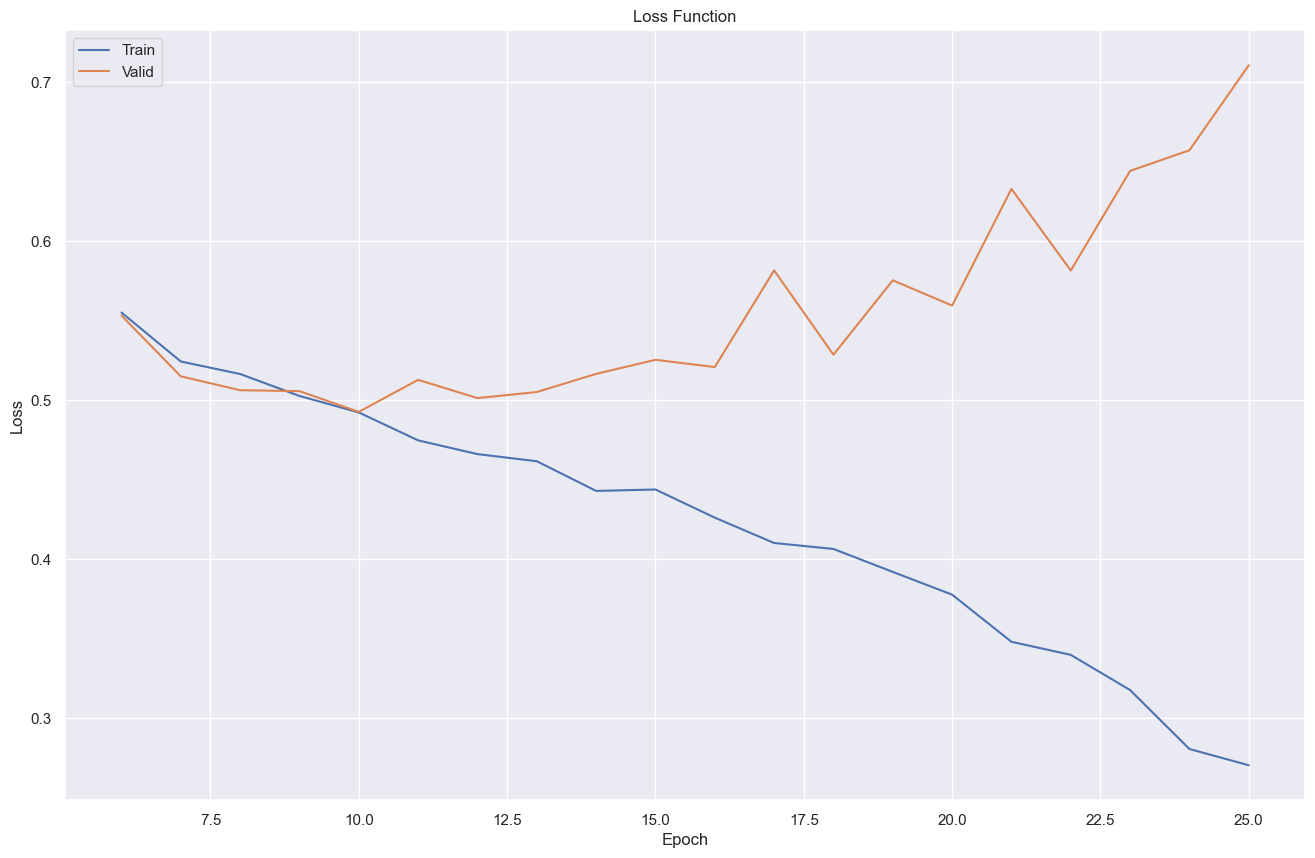

In [28]:
# Display the training and validation loss curves

cnn_plot.show_loss(
	report       = report,
	title        = 'Loss Function',
	filename     = os.path.join(OUT_PLOT, model.__name__),
	limit_bot    = None,
	limit_top    = None,
	start_index  = CONFIG['core/plots']
)

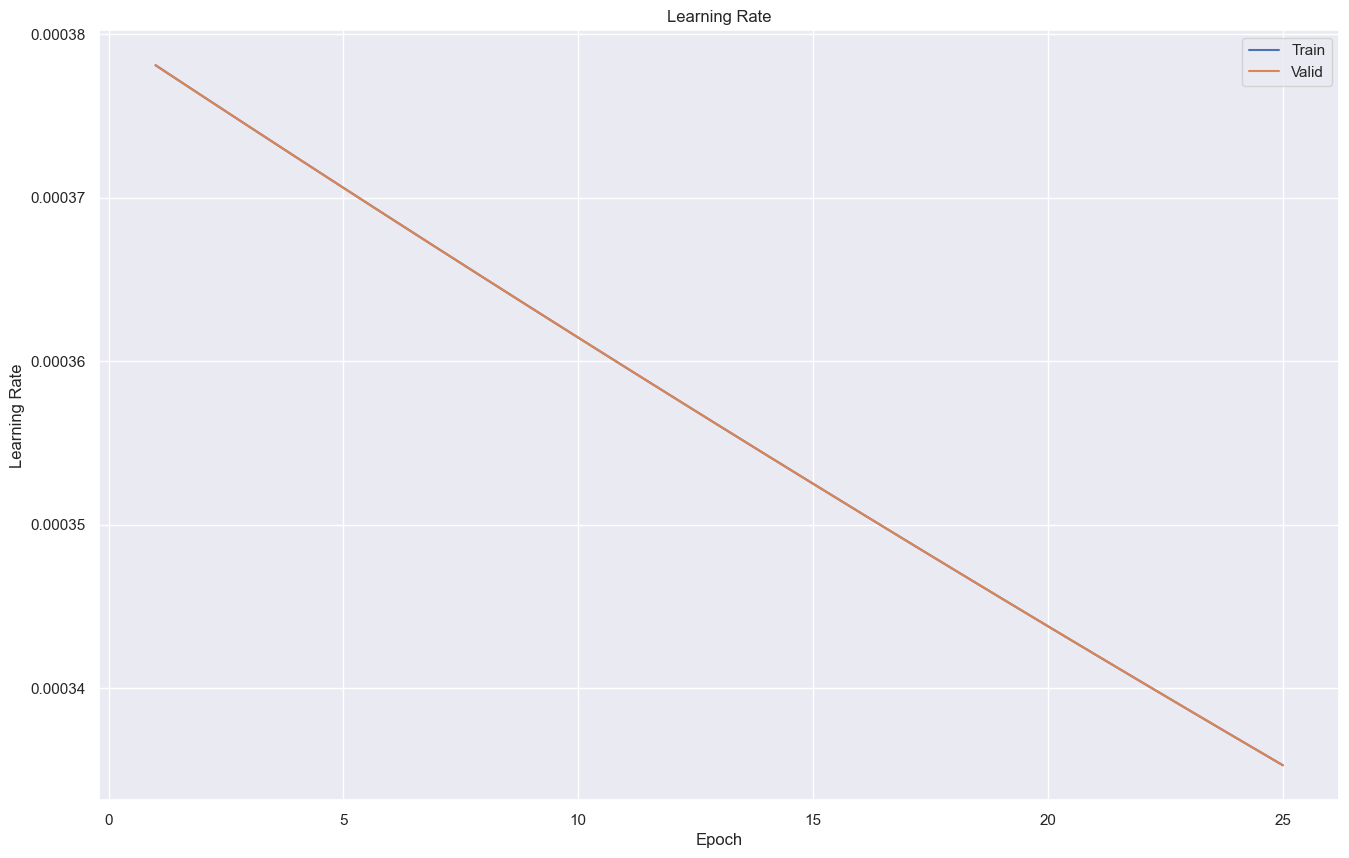

In [29]:
# Display the training and validation learning rate curves

cnn_plot.show_lr(
	report      = report,
	title       = 'Learning Rate',
	filename    = os.path.join(OUT_PLOT, model.__name__),
	limit_bot   = None,
	limit_top   = None,
	start_index = None
)

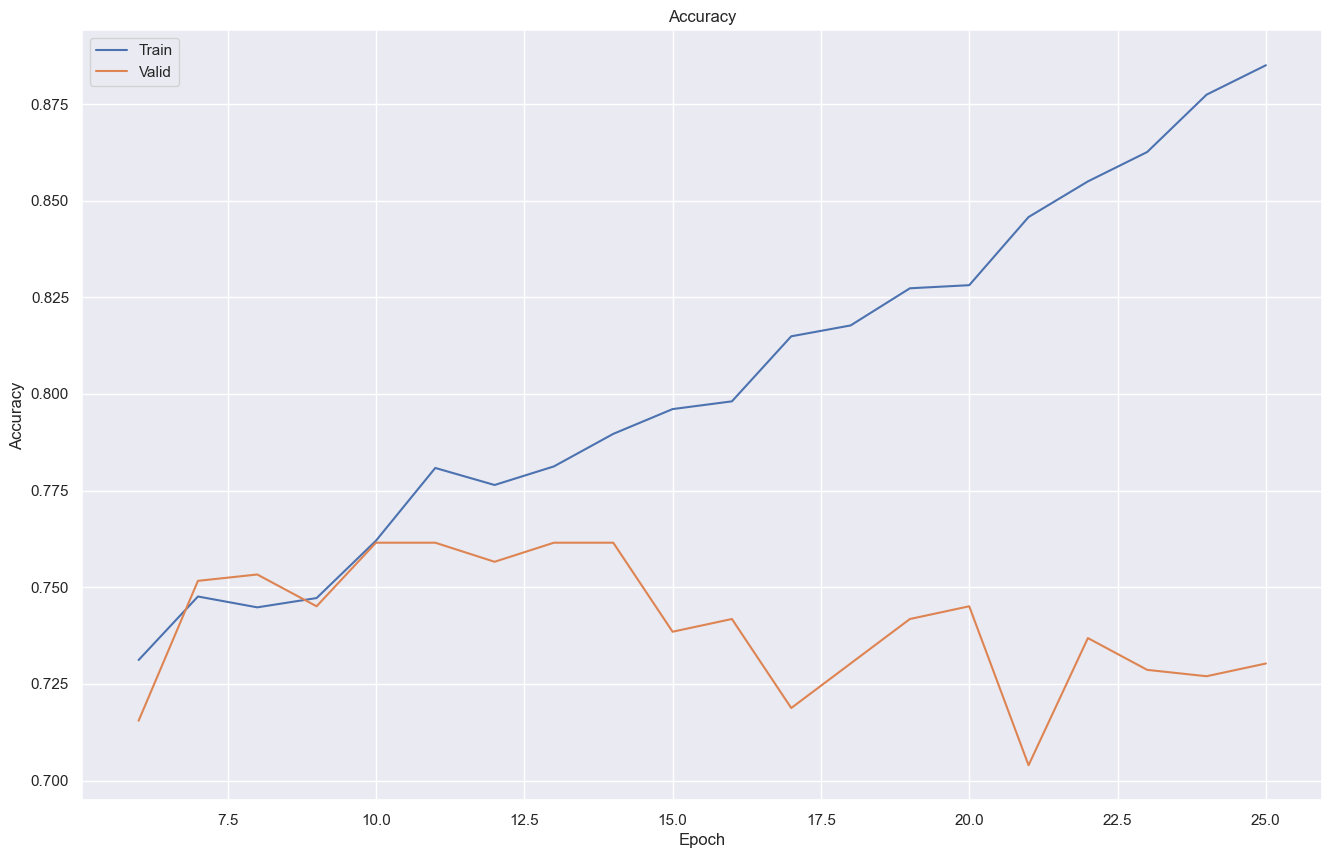

In [30]:
# Display the training and validation accuracy or r2 curves

if CONFIG['model/mode'] == 'regression' :
	cnn_plot.show_r2(
		report       = report,
		title        = 'R2 Score',
		filename     = os.path.join(OUT_PLOT, model.__name__),
		limit_bot    = None,
		limit_top    = None,
		start_index  = CONFIG['core/plots']
	)

if CONFIG['model/mode'] == 'classification' :
	cnn_plot.show_accuracy(
		report       = report,
		title        = 'Accuracy',
		filename     = os.path.join(OUT_PLOT, model.__name__),
		limit_bot    = None,
		limit_top    = None,
		start_index  = CONFIG['core/plots']
	)

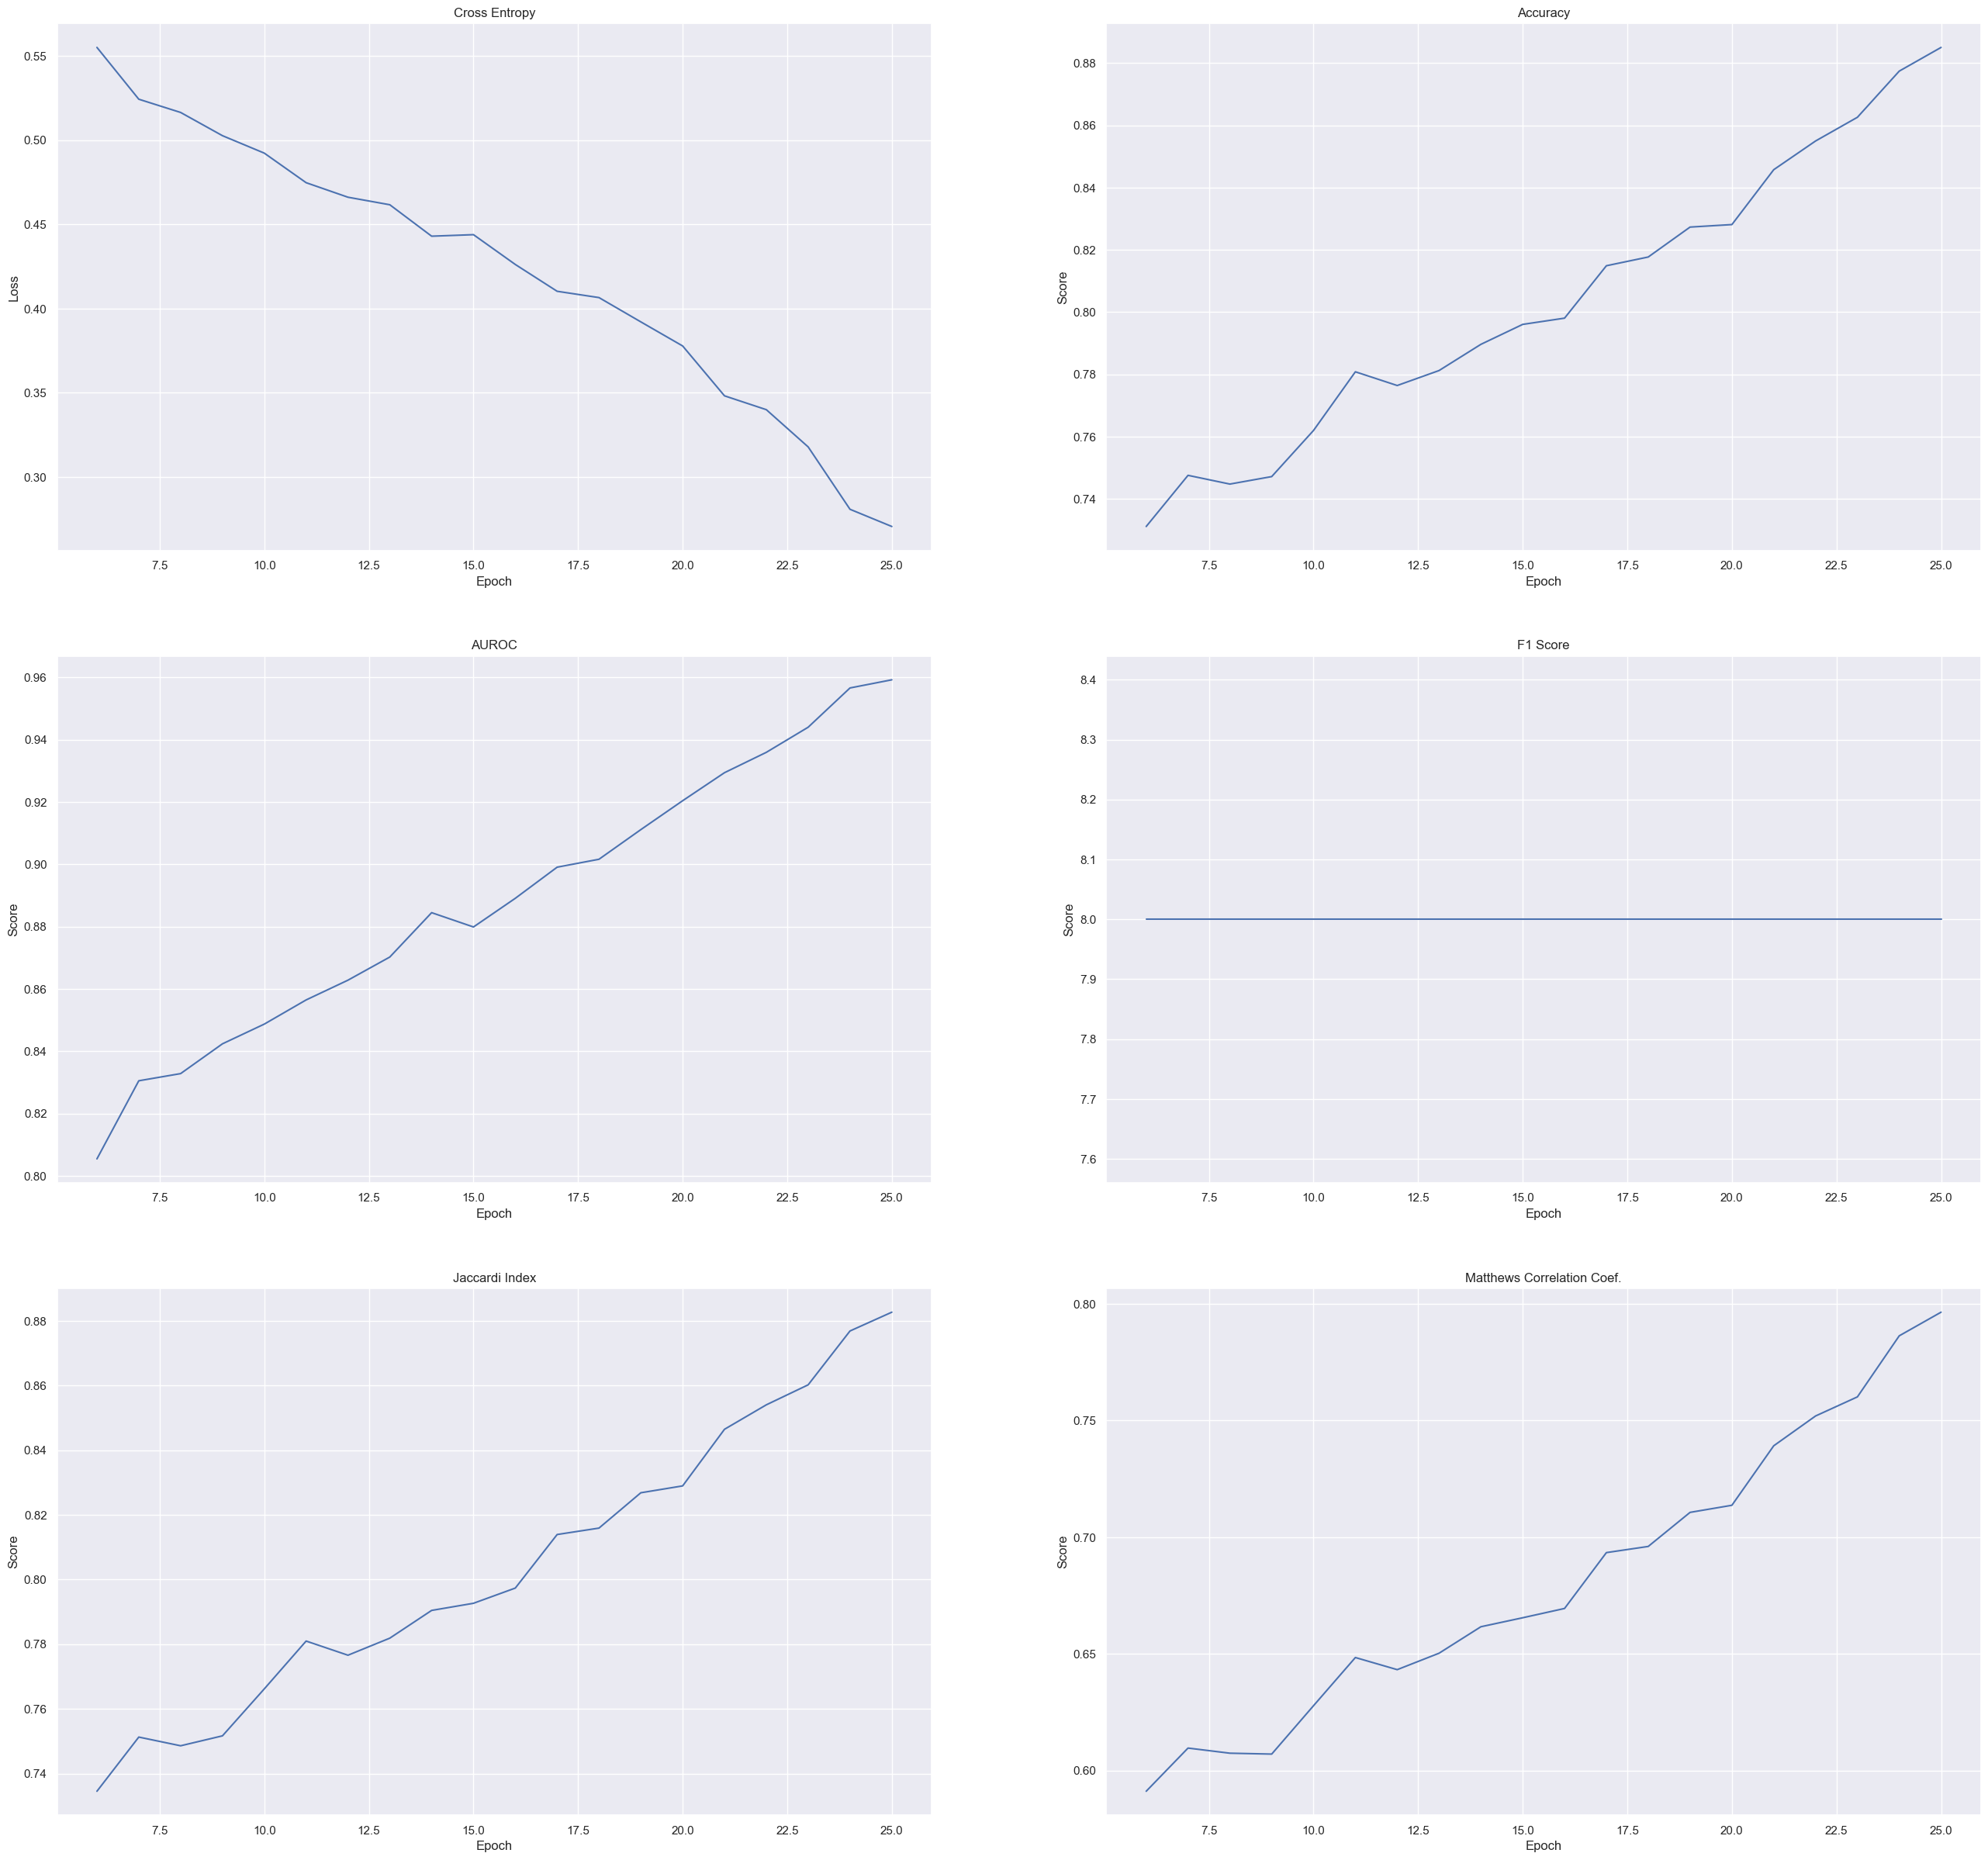

In [31]:
# Display the training metrics per batch

cnn_plot.show_metric_grid(
	report       = report,
	mode         = 'train',
	filename     = os.path.join(OUT_PLOT, model.__name__ + '-train'),
	apply_limits = False,
	start_index  = CONFIG['core/plots']
)

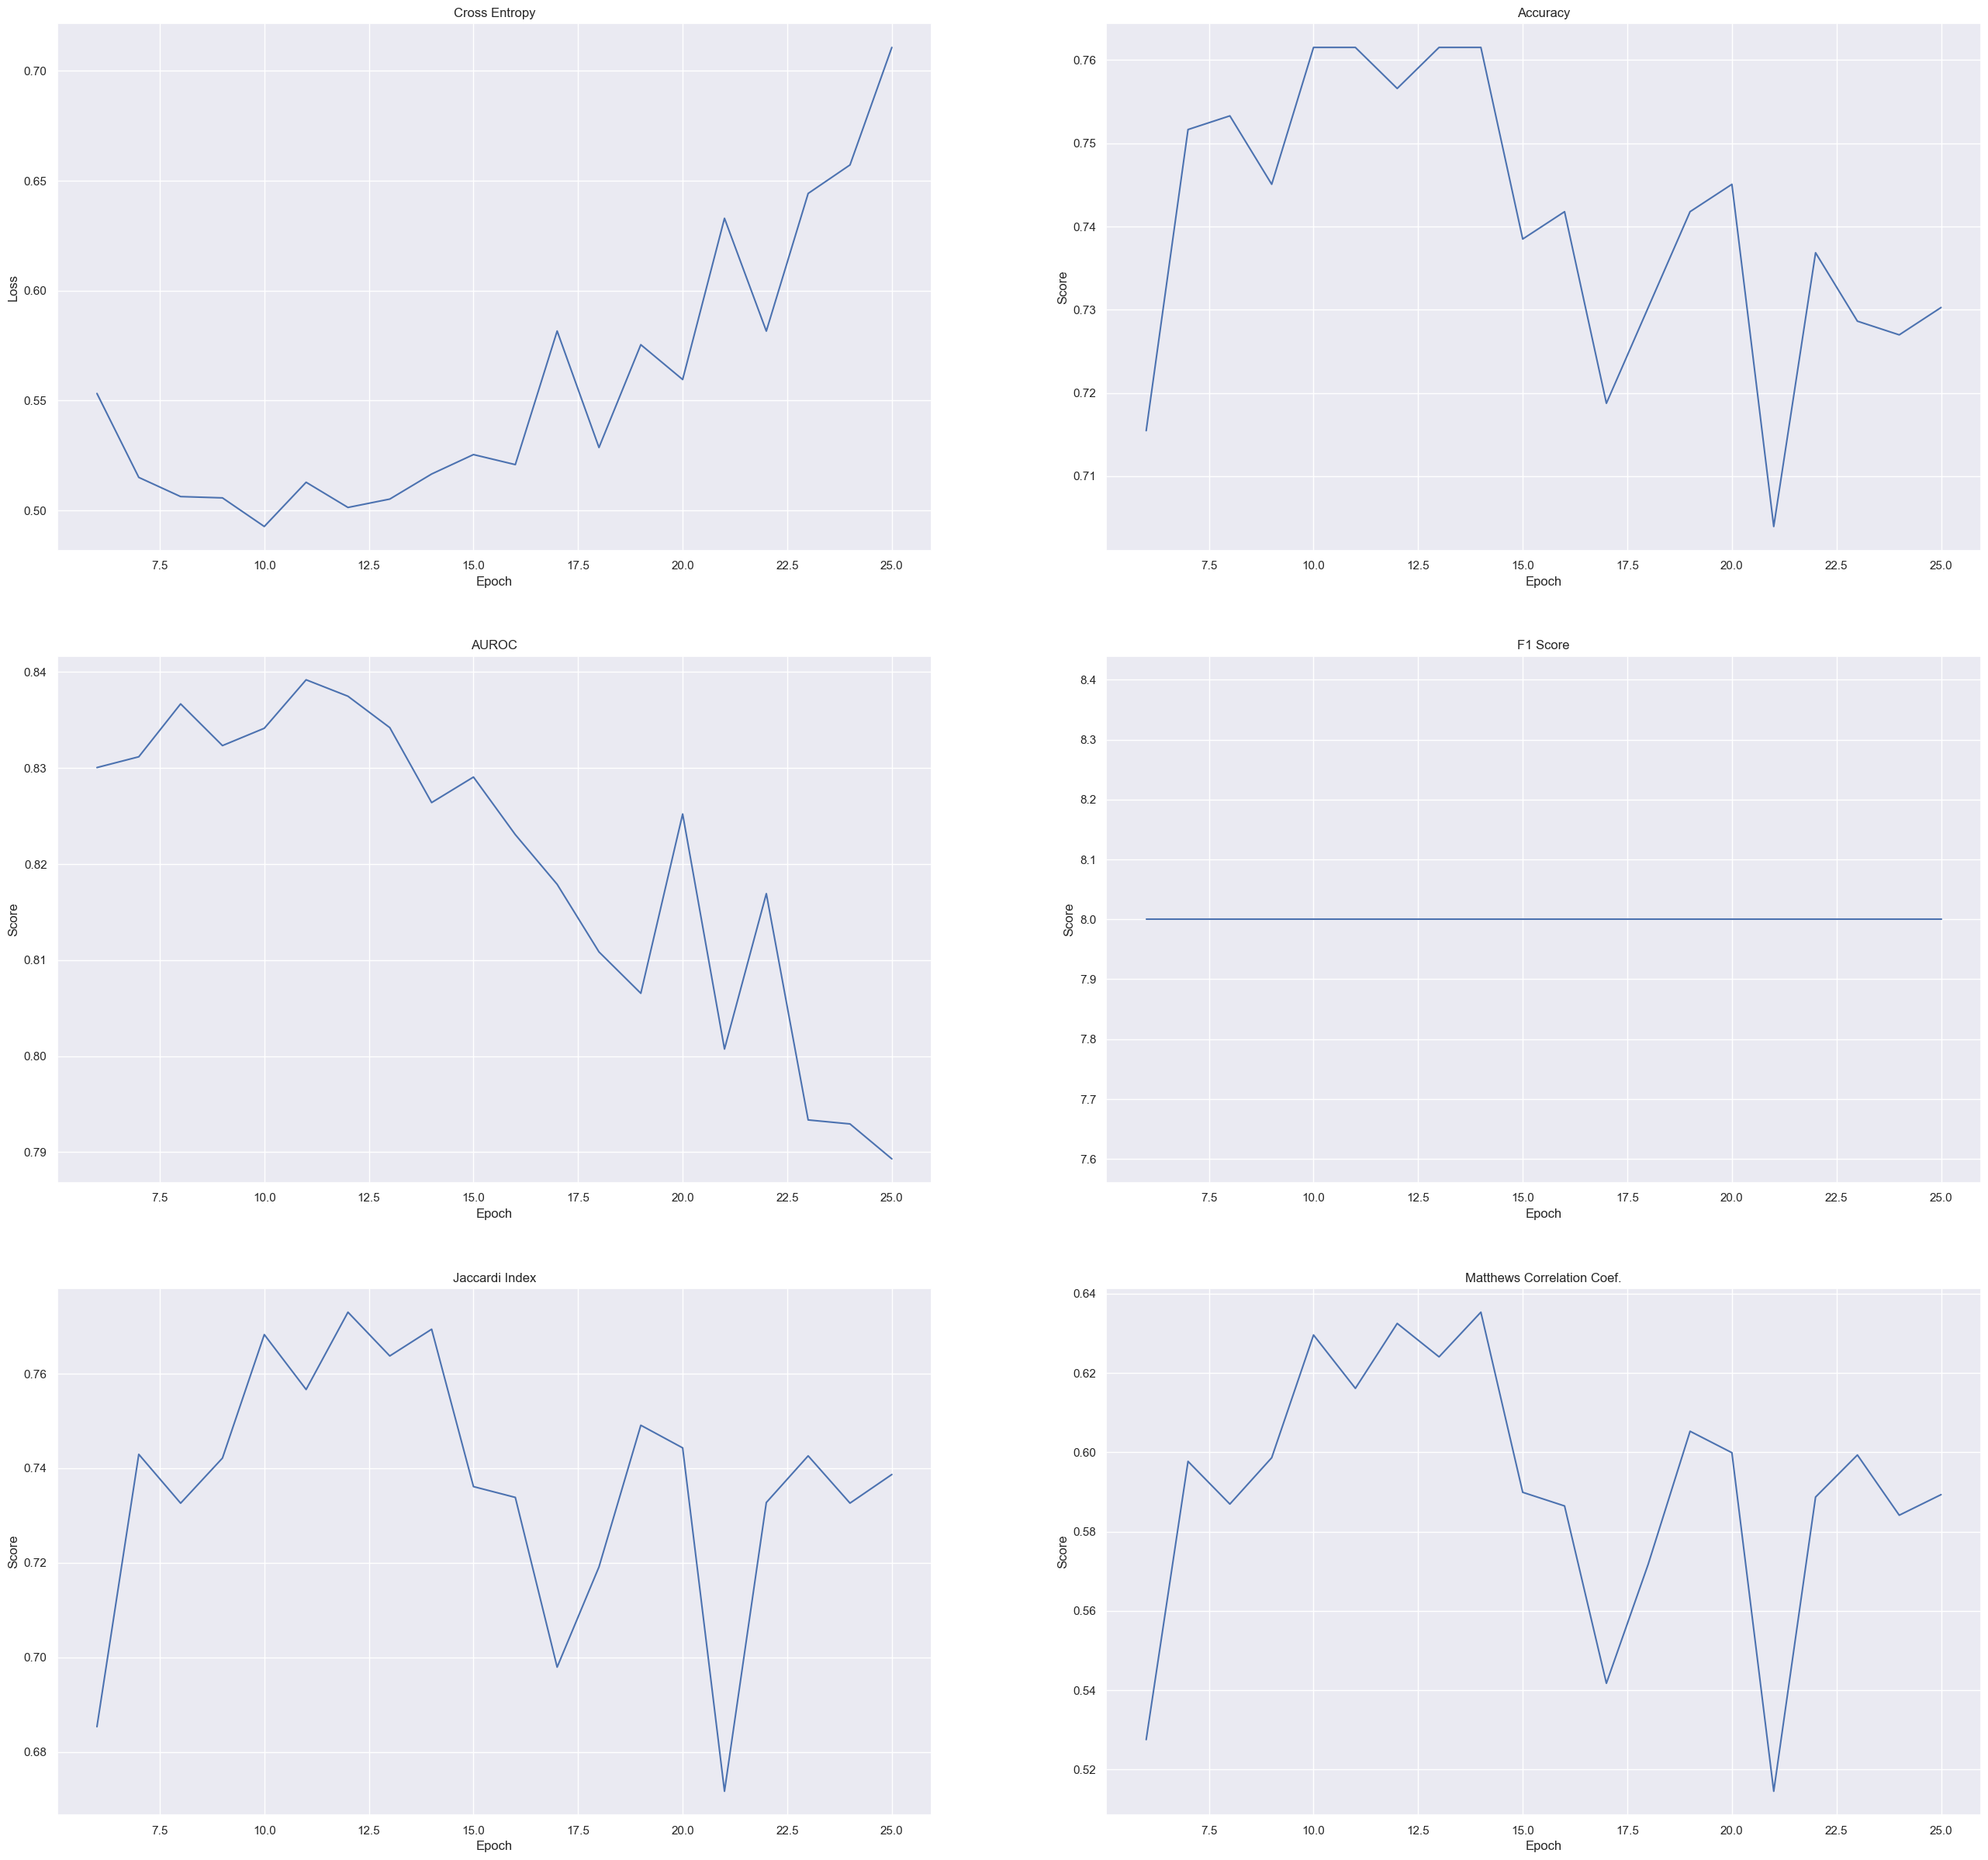

In [32]:
# Display the validation metrics per batch

cnn_plot.show_metric_grid(
	report       = report,
	mode         = 'valid',
	filename     = os.path.join(OUT_PLOT, model.__name__ + '-valid'),
	apply_limits = False,
	start_index  = CONFIG['core/plots']
)

# 5. Evaluation

## 5.1 Last Model

### 5.1.1 Evaluation

In [33]:
# Load last model

checkpoint = loader.load_torch(
	filename = os.path.join(OUT_MODEL, model.__name__ + '-last.pth')
)

final_report['evaluation/last/epoch'] = checkpoint['epoch']
final_report['evaluation/last/loss']  = checkpoint['loss']

print('Epoch : ' + '{}'.format(final_report['evaluation/last/epoch']))
print(' Loss : ' + '{:.5f}'.format(final_report['evaluation/last/loss']))
print()

model.load_state_dict(checkpoint['models'])

Epoch : 25
 Loss : 0.71060



<All keys matched successfully>

In [34]:
# Evaluate the full model

if CONFIG['model/mode'] == 'regression' :
	report = cnn_model.eval_regressor(
		model  = model,
		params = model_params
	)

	final_report['evaluation/last/r2/mean']    = report['eval']['metric']['r2'].mean()
	final_report['evaluation/last/mae/mean']   = report['eval']['metric']['mae'].mean()
	final_report['evaluation/last/mse/mean']   = report['eval']['metric']['mse'].mean()
	final_report['evaluation/last/mape/mean']  = report['eval']['metric']['mape'].mean()
	final_report['evaluation/last/wmape/mean'] = report['eval']['metric']['wmape'].mean()

	print('  R2 Score : ' + '{: 10.5f}'.format(final_report['evaluation/last/r2/mean']))
	print('  MAE Loss : ' + '{: 10.5f}'.format(final_report['evaluation/last/mae/mean']))
	print('  MSE Loss : ' + '{: 10.5f}'.format(final_report['evaluation/last/mse/mean']))
	print(' MAPE Loss : ' + '{: 10.5f}'.format(final_report['evaluation/last/mape/mean']))
	print('WMAPE Loss : ' + '{: 10.5f}'.format(final_report['evaluation/last/wmape/mean']))
	print()

if CONFIG['model/mode'] == 'classification' :
	report = cnn_model.eval_classifier(
		model  = model,
		params = model_params
	)

	final_report['evaluation/last/accuracy/mean'] = report['eval']['metric']['accuracy'].mean()
	final_report['evaluation/last/entropy/mean']  = report['eval']['metric']['entropy'].mean()
	final_report['evaluation/last/auroc/mean']    = report['eval']['metric']['auroc'].mean()
	final_report['evaluation/last/f1/mean']       = report['eval']['metric']['f1'].mean()
	final_report['evaluation/last/matthews/mean'] = report['eval']['metric']['matthews'].mean()

	print('Accuracy : ' + '{: 10.5f}'.format(final_report['evaluation/last/accuracy/mean']))
	print('Entropy  : ' + '{: 10.5f}'.format(final_report['evaluation/last/entropy/mean']))
	print('Auroc    : ' + '{: 10.5f}'.format(final_report['evaluation/last/auroc/mean']))
	print('F1       : ' + '{: 10.5f}'.format(final_report['evaluation/last/f1/mean']))
	print('Matthews : ' + '{: 10.5f}'.format(final_report['evaluation/last/matthews/mean']))
	print()

Accuracy :    0.76042
Entropy  :    0.57158
Auroc    :    0.84779
F1       :    0.77261
Matthews :    0.52486



## 5.2 Best Model

### 5.2.1 Evaluation

In [35]:
# Load best model

checkpoint = loader.load_torch(
	filename = os.path.join(OUT_MODEL, model.__name__ + '-best.pth')
)

final_report['evaluation/best/epoch'] = checkpoint['epoch']
final_report['evaluation/best/loss']  = checkpoint['loss']

print('Epoch : ' + '{}'.format(final_report['evaluation/best/epoch']))
print(' Loss : ' + '{:.5f}'.format(final_report['evaluation/best/loss']))
print()

model.load_state_dict(checkpoint['models'])

Epoch : 10
 Loss : 0.49273



<All keys matched successfully>

In [36]:
# Evaluate the full model

if CONFIG['model/mode'] == 'regression' :
	report_keep = cnn_model.eval_regressor(
		model  = model,
		params = model_params
	)

	final_report['evaluation/best/r2/mean']    = report_keep['eval']['metric']['r2'].mean()
	final_report['evaluation/best/mae/mean']   = report_keep['eval']['metric']['mae'].mean()
	final_report['evaluation/best/mse/mean']   = report_keep['eval']['metric']['mse'].mean()
	final_report['evaluation/best/mape/mean']  = report_keep['eval']['metric']['mape'].mean()
	final_report['evaluation/best/wmape/mean'] = report_keep['eval']['metric']['wmape'].mean()

	print('  R2 Score : ' + '{: 10.5f}'.format(final_report['evaluation/best/r2/mean']))
	print('  MAE Loss : ' + '{: 10.5f}'.format(final_report['evaluation/best/mae/mean']))
	print('  MSE Loss : ' + '{: 10.5f}'.format(final_report['evaluation/best/mse/mean']))
	print(' MAPE Loss : ' + '{: 10.5f}'.format(final_report['evaluation/best/mape/mean']))
	print('WMAPE Loss : ' + '{: 10.5f}'.format(final_report['evaluation/best/wmape/mean']))
	print()

if CONFIG['model/mode'] == 'classification' :
	report_keep = cnn_model.eval_classifier(
		model  = model,
		params = model_params
	)

	final_report['evaluation/best/accuracy/mean'] = report_keep['eval']['metric']['accuracy'].mean()
	final_report['evaluation/best/entropy/mean']  = report_keep['eval']['metric']['entropy'].mean()
	final_report['evaluation/best/auroc/mean']    = report_keep['eval']['metric']['auroc'].mean()
	final_report['evaluation/best/f1/mean']       = report_keep['eval']['metric']['f1'].mean()
	final_report['evaluation/best/matthews/mean'] = report_keep['eval']['metric']['matthews'].mean()

	print('Accuracy : ' + '{: 10.5f}'.format(final_report['evaluation/best/accuracy/mean']))
	print('Entropy  : ' + '{: 10.5f}'.format(final_report['evaluation/best/entropy/mean']))
	print('Auroc    : ' + '{: 10.5f}'.format(final_report['evaluation/best/auroc/mean']))
	print('F1       : ' + '{: 10.5f}'.format(final_report['evaluation/best/f1/mean']))
	print('Matthews : ' + '{: 10.5f}'.format(final_report['evaluation/best/matthews/mean']))
	print()

Accuracy :    0.78255
Entropy  :    0.46158
Auroc    :    0.86332
F1       :    0.79264
Matthews :    0.55843



### 5.2.2 Custom

In [37]:
# Display the first few evaluation item predictions and expectations

if CONFIG['model/mode'] == 'regression' :
	cnn_utils.display_regression_predictions(
		report = report_keep,
		n      = 2
	)

if CONFIG['model/mode'] == 'classification' :
	cnn_utils.display_classification_predictions(
		report = report_keep,
		n      = 2,
		binary = True
	)

    Key : AT3G57210.1
    True : [ 0.00000]
    Pred : [ 0.86114]
 Entropy : [ 1.97430]
Accuracy : [ 0.81250]

    Key : AT1G09510.1
    True : [ 0.00000]
    Pred : [ 0.13168]
 Entropy : [ 0.14119]
Accuracy : [ 0.81250]



### 5.2.3 Visualization

In [38]:
# Display prediction error per group

if CONFIG['model/mode'] == 'regression' :
	cnn_plot.show_prediction_error_grid(
		report   = report_keep,
		order    = target_order_keep,
		filename = os.path.join(OUT_PLOT, model.__name__ + '-best')
	)

In [39]:
# Display prediction linear regression per group

if CONFIG['model/mode'] == 'regression' :
	cnn_plot.show_linear_regression_grid(
		report   = report_keep,
		order    = target_order_keep,
		filename = os.path.join(OUT_PLOT, model.__name__ + '-best')
	)

# 6. Save

In [40]:
# Convert reports from numpy array to lists

def ensure_json_validity (item) :
	if   isinstance(item, dict)          : pass
	elif isinstance(item, list)          : return item
	elif isinstance(item, numpy.ndarray) : return item.tolist()
	elif isinstance(item, float)         : return item
	elif isinstance(item, int)           : return item
	elif isinstance(item, str)           : return item
	else                                 : return None

	data = dict()

	for key in item.keys() :
		data[key] = ensure_json_validity(item[key])

	return data

report_keep = ensure_json_validity(report_keep)

In [41]:
# Save results

for key, value in final_report.items() :
	if isinstance(value, numpy.float32) :
		final_report[key] = float(value)

writer.write_json(
	data     = final_report,
	filename = os.path.join(OUT_DATA, 'report.json')
)

writer.write_json(
	data     = report_keep,
	filename = os.path.join(OUT_DATA, 'report_keep.json')
)

writer.write_json(
	data     = {k : v for k, v in CONFIG.items() if k != 'core/device'},
	filename = os.path.join(OUT_DATA, 'config.json')
)